# Gradient-free Global Maximum Likelihood Finding: Neural Networks

Neural network training is typically done with maximum likelihood estimation. Given the number of parameter invariances, and symmetries in neural network architectures, this often introduces a large number of local minima, making global optimisation very difficult.

JAXNS uses slice sampling as a gradient-free way to sample from hard-likelihood constraints, starting from small likelihoods and strictly increasing towards a maximum likelihood. This actually means that JAXNS is performing global maximisation of the likelihood. The prior can be seen as a measure which guides where JAXNS looks first. An attractive idea is to think about the prior as a guide for efficient global maximisation with JAXNS, but that's for another tutorial ;).

## Overview

In this tutorial we'll cover:
1. How to build a JAXNS model of a neural network using [Haiku](https://github.com/deepmind/dm-haiku)
2. How to do global likelihood maximisation with JAXNS

In [1]:
try:
    import haiku as hk
except ImportError:
    print("You must `pip install dm-haiku` first.")

from jax import numpy as jnp, random, vmap
import jax
from jax.flatten_util import ravel_pytree

from jaxns import PriorChain, NormalPrior
from jaxns import NestedSampler, marginalise_static, resample
from jaxns.plotting import plot_diagnostics
from jaxns.utils import summary
from jax.scipy.optimize import minimize
from itertools import product

# for parallel sampling
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"



In [2]:
# Generate data

def xor_reduce(x):
    """
    Computes the XOR reduction on a sequence of bits.

    Examples:
        100 -> xor(xor(1,0),0) = 1
        001 -> xor(xor(0,0),1) = 1
        110 -> xor(xor(1,1),0) = 0
        011 -> xor(xor(0,1),1) = 0

    Args:
        x: boolean vector of bits.

    Returns:
        bool, scalar
    """
    output = x[0]
    for i in range(1, x.shape[-1]):
        output = jnp.logical_xor(output, x[i])
    return output


num_variables = 7
options = [True, False]
x = jnp.asarray(list(product(options, repeat=num_variables)))#N,2
y = vmap(xor_reduce)(x)[:, None]#N, 1
x = x.astype(jnp.float32)
print("Data:")

for input, output in zip(x,y):
    print(f"{input} -> {output}")


INFO[2022-03-26 01:39:35,149]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-03-26 01:39:35,150]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO[2022-03-26 01:39:35,152]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-03-26 01:39:35,152]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Data:
[1. 1. 1. 1. 1. 1. 1.] -> [ True]
[1. 1. 1. 1. 1. 1. 0.] -> [False]
[1. 1. 1. 1. 1. 0. 1.] -> [False]
[1. 1. 1. 1. 1. 0. 0.] -> [ True]
[1. 1. 1. 1. 0. 1. 1.] -> [False]
[1. 1. 1. 1. 0. 1. 0.] -> [ True]
[1. 1. 1. 1. 0. 0. 1.] -> [ True]
[1. 1. 1. 1. 0. 0. 0.] -> [False]
[1. 1. 1. 0. 1. 1. 1.] -> [False]
[1. 1. 1. 0. 1. 1. 0.] -> [ True]
[1. 1. 1. 0. 1. 0. 1.] -> [ True]
[1. 1. 1. 0. 1. 0. 0.] -> [False]
[1. 1. 1. 0. 0. 1. 1.] -> [ True]
[1. 1. 1. 0. 0. 1. 0.] -> [False]
[1. 1. 1. 0. 0. 0. 1.] -> [False]
[1. 1. 1. 0. 0. 0. 0.] -> [ True]
[1. 1. 0. 1. 1. 1. 1.] -> [False]
[1. 1. 0. 1. 1. 1. 0.] -> [ True]
[1. 1. 0. 1. 1. 0. 1.] -> [ True]
[1. 1. 0. 1. 1. 0. 0.] -> [False]
[1. 1. 0. 1. 0. 1. 1.] -> [ True]
[1. 1. 0. 1. 0. 1. 0.] -> [False]
[1. 1. 0. 1. 0. 0. 1.] -> [False]
[1. 1. 0. 1. 0. 0. 0.] -> [ True]
[1. 1. 0. 0. 1. 1. 1.] -> [ True]
[1. 1. 0. 0. 1. 1. 0.] -> [False]
[1. 1. 0. 0. 1. 0. 1.] -> [False]
[1. 1. 0. 0. 1. 0. 0.] -> [ True]
[1. 1. 0. 0. 0. 1. 1.] -> [False]
[1. 1. 0

In [3]:
# Define the likelihood, using Haiku as our framework for neural networks

def model(x, is_training=False):
    mlp = hk.Sequential([hk.Linear(4),
                         jax.nn.sigmoid,
                         hk.Linear(1)])
    return mlp(x)

model = hk.without_apply_rng(hk.transform(model))
# We must call the model once to get the params shape and type as a big pytree
# We then use ravel_pytree to flatten and get the unflatten function.
init_params = model.init(random.PRNGKey(2345), x)
init_params_flat, unravel_func = ravel_pytree(init_params)
n_dims = init_params_flat.size
print("Number of parameters:", n_dims)

def softplus(x):
    return jnp.log1p(jnp.exp(x))

def log_likelihood(params):
    """
    log(P(y|p))
    p = exp(logits)/1 - exp(logits)
    = log(p) * y + log(1-p) * (1-y)
    = logits * y1 - log(exp(-logits)/(exp(-logits) - 1)) * y0
    """
    params_dict = unravel_func(params)
    logits = model.apply(params_dict, x)
    log_prob0, log_prob1 = -softplus(logits), -softplus(-logits)
    #log(p) * y + log(1-p) * (1-y)
    log_prob = jnp.mean(jnp.where(y, log_prob1, log_prob0))
    return jnp.asarray(log_prob, jnp.float64)


Number of parameters: 37


In [4]:
# Let us compare the results of nested sampling to optimisation done with BFGS

params_bfgs = minimize(lambda p: -log_likelihood(p),
                   random.normal(random.PRNGKey(2435), shape=(n_dims,)),
                   method='BFGS').x
print(f"BFGS maximum likelihood solution: log(L) = {log_likelihood(params_bfgs)}")

/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3610: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3610: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/home/albert/miniconda

BFGS maximum likelihood solution: log(L) = -0.6931479573249817


/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3610: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")


In [5]:

# Build the model

with PriorChain() as prior_chain:
    # we'll effectively place no prior on the parameters, other than requiring them to be within [-10,10]
    NormalPrior('params', jnp.zeros(n_dims), 1.*jnp.ones(n_dims))

# We'll do some strange things here.
# num_slices -> low: We'll make the sampler do very few slices. This will lead to large correlation between samples, and poor estimate of the evidence.
# This is alright, because we'll be looking for the maximum likelihood solution.
ns = NestedSampler(loglikelihood=log_likelihood, prior_chain=prior_chain,
                   num_parallel_samplers=4,
                   sampler_kwargs=dict(gradient_boost=True))


/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3662: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")
WARNING[2022-03-26 01:39:39,378]: Increasing max_samples (100000) by 3600 to evenly divide samples_per_step


In [6]:
# Let's test the model with a small sanity check.
prior_chain.test_prior(random.PRNGKey(42), 10, log_likelihood)

/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3610: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
INFO[2022-03-26 01:39:40,211]: Log-likelihood: -0.7780163884162903
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3610: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._

In [7]:
# We do another strange thing here: we set the number of live points really low, which is okay because we don't care about evidence (yet)
# ns = jit(ns, static_argnames='maximise_likelihood')
results = ns(random.PRNGKey(42), termination_live_evidence_frac=1e-5)

/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3662: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3610: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/home/albert/miniconda3/envs/j

WARNING[2022-03-26 01:40:34,987]: No handles with labels found to put in legend.


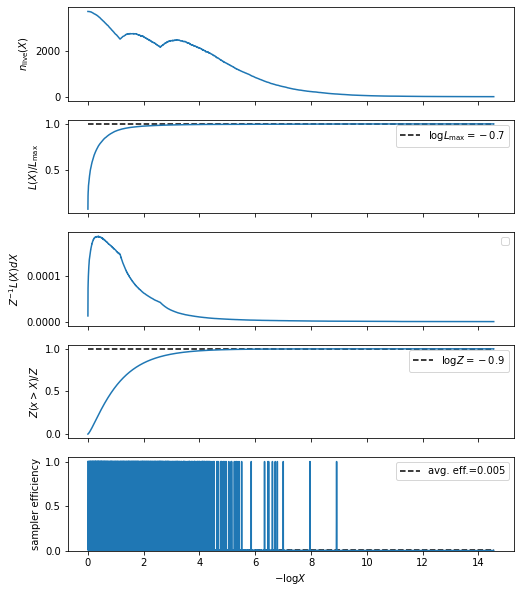

In [9]:
# summary(results)
plot_diagnostics(results)

In [12]:
samples = resample(random.PRNGKey(45), results.samples, results.log_dp_mean, S=int(results.ESS), replace=True)

def predict(params):
    params_dict = unravel_func(params)
    logits = model.apply(params_dict, x)
    return jax.nn.sigmoid(logits)[:,0]

predictions = vmap(predict)(samples['params'])

for i in range(len(y)):
    print(f"{i}: {x[i]} -> {y[i]} | pred: {jnp.percentile(predictions[:,i],jnp.asarray([5,50,95]))}")

0: [1. 1. 1. 1. 1. 1. 1.] -> [ True] | pred: [0.10859276 0.49606484 0.88965696]
1: [1. 1. 1. 1. 1. 1. 0.] -> [False] | pred: [0.11426362 0.49046564 0.89101255]
2: [1. 1. 1. 1. 1. 0. 1.] -> [False] | pred: [0.11192001 0.49549934 0.888786  ]
3: [1. 1. 1. 1. 1. 0. 0.] -> [ True] | pred: [0.11377474 0.49031085 0.89095294]
4: [1. 1. 1. 1. 0. 1. 1.] -> [False] | pred: [0.11171093 0.49344707 0.886772  ]
5: [1. 1. 1. 1. 0. 1. 0.] -> [ True] | pred: [0.11243504 0.4920469  0.8908259 ]
6: [1. 1. 1. 1. 0. 0. 1.] -> [ True] | pred: [0.11209509 0.49837047 0.8894648 ]
7: [1. 1. 1. 1. 0. 0. 0.] -> [False] | pred: [0.11341892 0.49423862 0.8910013 ]
8: [1. 1. 1. 0. 1. 1. 1.] -> [False] | pred: [0.10975948 0.49530315 0.88968176]
9: [1. 1. 1. 0. 1. 1. 0.] -> [ True] | pred: [0.10808629 0.49072883 0.8916272 ]
10: [1. 1. 1. 0. 1. 0. 1.] -> [ True] | pred: [0.11180017 0.49973756 0.8929305 ]
11: [1. 1. 1. 0. 1. 0. 0.] -> [False] | pred: [0.11314723 0.4940728  0.8948275 ]
12: [1. 1. 1. 0. 0. 1. 1.] -> [ True] 

0: [1. 1. 1. 1. 1. 1. 1.] -> [ True] | pred: [0.10859276 0.49606484 0.88965696]
1: [1. 1. 1. 1. 1. 1. 0.] -> [False] | pred: [0.10859276 0.49606484 0.88965696]
2: [1. 1. 1. 1. 1. 0. 1.] -> [False] | pred: [0.10859276 0.49606484 0.88965696]
3: [1. 1. 1. 1. 1. 0. 0.] -> [ True] | pred: [0.10859276 0.49606484 0.88965696]
4: [1. 1. 1. 1. 0. 1. 1.] -> [False] | pred: [0.10859276 0.49606484 0.88965696]
5: [1. 1. 1. 1. 0. 1. 0.] -> [ True] | pred: [0.10859276 0.49606484 0.88965696]
6: [1. 1. 1. 1. 0. 0. 1.] -> [ True] | pred: [0.10859276 0.49606484 0.88965696]
7: [1. 1. 1. 1. 0. 0. 0.] -> [False] | pred: [0.10859276 0.49606484 0.88965696]
8: [1. 1. 1. 0. 1. 1. 1.] -> [False] | pred: [0.10859276 0.49606484 0.88965696]
9: [1. 1. 1. 0. 1. 1. 0.] -> [ True] | pred: [0.10859276 0.49606484 0.88965696]
10: [1. 1. 1. 0. 1. 0. 1.] -> [ True] | pred: [0.10859276 0.49606484 0.88965696]
11: [1. 1. 1. 0. 1. 0. 0.] -> [False] | pred: [0.10859276 0.49606484 0.88965696]
12: [1. 1. 1. 0. 0. 1. 1.] -> [ True] 